In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset3
from tqdm.notebook import tqdm

from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
def column_norm(x):
    xn  = x - np.mean(x, axis=1, keepdims=True) # remove mean
    xn /= np.sqrt(np.sum(xn**2, axis=1, keepdims=True)) # normalize
    return xn.sum(2)


def find_similar_column(col0, xn1):
    ''' calculates cosine similarity between the normalized reference column col0 and all columns
        in the column-normalized sample xn1 '''
    return np.array([ [ np.dot(col0, col1) for col1 in img.T ] for img in xn1 ])

In [6]:
train = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v18v.csv')
train = train.loc[train['target'] != -1]

In [5]:
freqs = []
for gid in test['id'].values:
    with open(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle', 'rb') as f:
        data = pickle.load(f)[gid]
    freqs.append(data['frequency_Hz'][0])

KeyboardInterrupt: 

In [7]:
test['freq'] = freqs

In [9]:
test['freq'].value_counts()

77.559444     2
369.861667    2
101.064444    2
78.425000     2
137.874444    2
             ..
393.984444    1
489.551111    1
374.142222    1
246.197222    1
138.683333    1
Name: freq, Length: 7947, dtype: int64

In [28]:
test.query('77.5 <= freq <= 77.6')

,id,target,freq
4496,9044f0eed,0.5,77.559444
4535,914b6a6c3,0.5,77.559444


In [41]:
test.query('369.8 <= freq <= 369.9')

,id,target,freq
1278,29578d353,0.5,369.861667
2841,5b3475e11,0.5,369.888333
3688,76a0a0217,0.5,369.876111
3918,7cdc4b9ba,0.5,369.856111
4028,80b0e4c16,0.5,369.876111
4173,856831ddf,0.5,369.862778
5633,b530f8500,0.5,369.861667
5874,bc6bccbf3,0.5,369.807778
6719,d678430aa,0.5,369.809444


In [49]:
ds = G2Net2022Dataset3(
    # test.query('369.85 <= freq <= 369.88'), 
    test.loc[test['id'].isin(['76a0a0217', '80b0e4c16'])],
    match_time=False,
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(8), NormalizeSpectrogram('constant')]),
    transforms=ToTensorV2()
    )

In [27]:
def match_spectrogram(spec1, spec2, time1, time2):
    _spec = np.full((2, 360, 5760), 0, np.float32)
    ref_time = min(time1.min(), time2.min())
    frame1 = ((time1 - ref_time) / 1800).round().astype(np.uint64)
    frame2 = ((time2 - ref_time) / 1800).round().astype(np.uint64)
    _spec[0][:, frame1[frame1 < 5760]] = spec1[:, frame1 < 5760]
    _spec[1][:, frame2[frame2 < 5760]] = spec2[:, frame2 < 5760]
    return _spec[0], _spec[1]


def load_data(gid):
    with open(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle', 'rb') as f:
        data = pickle.load(f)[gid]
    spec_h1 = data['H1']['SFTs']*1e22
    spec_h1 = spec_h1.real**2 + spec_h1.imag**2
    spec_l1 = data['L1']['SFTs']*1e22
    spec_l1 = spec_l1.real**2 + spec_l1.imag**2
    time_h1 = data['H1']['timestamps_GPS']
    time_l1 = data['L1']['timestamps_GPS']
    return spec_h1, spec_l1, time_h1, time_l1


def load_data_valid(gid):
    with open(f'input/g2net-detecting-continuous-gravitational-waves/v18v/{gid}.pickle', 'rb') as f:
        data = pickle.load(f)
    spec = data['H1']['spectrogram']
    return spec

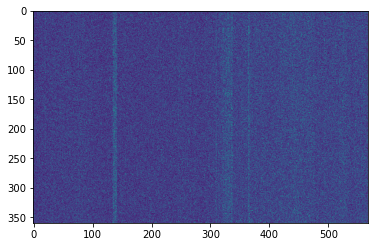

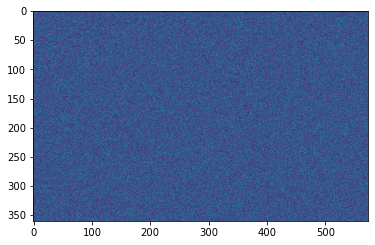

In [63]:
for spec, _ in ds:
    plt.imshow(spec[1])
    plt.show()
    plt.close()

In [64]:
_, spec1, _, time1 = load_data('76a0a0217')
_, spec2, _, time2 = load_data('80b0e4c16')
spec1a, spec2a = match_spectrogram(spec1, spec2, time1, time2)

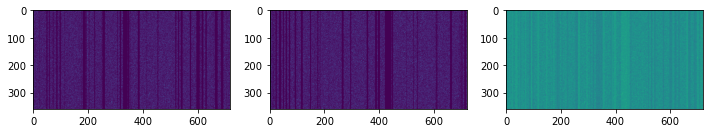

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(spec1a[:, :720])
plt.subplot(1, 3, 2)
plt.imshow(spec2a[:, :720])
plt.subplot(1, 3, 3)
plt.imshow(spec1a[:, :720] - np.roll(spec2a[:, :720], 1, axis=1))
plt.show()
plt.close()

In [67]:
# for i in np.arange(-20, 20):
#     print(i, (spec1a[:, :360] - np.roll(spec2a[:, :360], i, axis=1)).mean())

In [28]:
spec_test = load_data('3c451363c')[0]
spec_valid = load_data_valid('3c451363c_negative')

In [33]:
spec_test.mean(), (spec_valid / 2.295 * 2.25).mean()

(2.2479508, 2.25)

In [41]:
spec_test.std(), (spec_valid / 2.295 * 2.25).astype(np.float32).std()

(2.2491856, 2.3142676)